In [2]:
# Install Pytorch & other libraries
!pip install "torch==2.1.2" tensorboard
 
# Install Hugging Face libraries
!pip install --upgrade \
  "sentence-transformers>=3" \
  "datasets==2.19.1"  \
  "transformers==4.41.2" 

In [3]:
!pip install accelerate -U

In [4]:
!pip install datasets

In [5]:
from datasets import load_dataset

# Load T-REx from KILT
dataset = load_dataset("kilt_tasks", "trex")

#### Inspect the data

In [6]:
# Inspect the dataset structure
#print(dataset)

# Check the first example
print(dataset['train'][5]['output'])


[{'answer': 'Canada', 'meta': {'score': -1}, 'provenance': [{'bleu_score': 1.0, 'start_character': 127, 'start_paragraph_id': 1, 'end_character': 230, 'end_paragraph_id': 1, 'meta': {'fever_page_id': '', 'fever_sentence_id': -1, 'annotation_id': '-1', 'yes_no_answer': '', 'evidence_span': []}, 'section': 'Section::::Abstract.', 'title': 'Norfolk County Fair and Horse Show', 'wikipedia_id': '4892372'}]}, {'answer': 'CA', 'meta': {'score': -1}, 'provenance': []}, {'answer': 'Dominion of Canada', 'meta': {'score': -1}, 'provenance': []}, {'answer': 'can', 'meta': {'score': -1}, 'provenance': []}, {'answer': 'British North America', 'meta': {'score': -1}, 'provenance': []}, {'answer': '🇨🇦', 'meta': {'score': -1}, 'provenance': []}, {'answer': 'CAN', 'meta': {'score': -1}, 'provenance': []}, {'answer': 'ca', 'meta': {'score': -1}, 'provenance': []}, {'answer': 'CDN', 'meta': {'score': -1}, 'provenance': []}]


#### Data transformation for training the model

In [7]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

In [8]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Tokenize function
def tokenize_inputs(example):
    return tokenizer(example["input"], padding=True, truncation=True)

# Tokenize in parallel
tokenized_dataset = dataset["train"].map(
    tokenize_inputs, 
    batched=True, 
    num_proc=4  
)

#### DT we need

In [9]:
def create_pairs(example):
    if isinstance(example["output"], list):
        pairs = [
            (example["input"], answer["answer"])
            for answer in example["output"]
            if isinstance(answer, dict) and "answer" in answer
        ]
        return {"pairs": pairs if pairs else [("EMPTY", "EMPTY")]}
    else:
        # Handle invalid cases
        print(f"Skipping invalid output: {example['output']}")
        return {"pairs": [("EMPTY", "EMPTY")]}

# Parallelize the operation
pairs_dataset = dataset["train"].map(
    create_pairs,
    num_proc=4,       
)

In [10]:
pairs_dataset

Dataset({
    features: ['id', 'input', 'meta', 'output', 'pairs'],
    num_rows: 2284168
})

In [11]:
from datasets import DatasetDict
import random

# Optimization: Transform pairs using map with batched processing
def transform_pairs_with_metadata_batch(examples):
    transformed_pairs = {
        "id": [],
        "input": [],
        "output": [],
        "label": [],
        "entity_type": [],
        "left_context": [],
        "right_context": [],
        "provenance": [],
        "score": [],
    }
    
    for example_id, example_input, example_meta, example_output in zip(
        examples["id"], examples["input"], examples["meta"], examples["output"]
    ):
        for answer in example_output:
            if "answer" in answer and "meta" in answer:
                transformed_pairs["id"].append(example_id)
                transformed_pairs["input"].append(example_input)
                transformed_pairs["output"].append(answer["answer"])
                transformed_pairs["label"].append(1 if answer["meta"]["score"] >= 0 else 0)
                transformed_pairs["entity_type"].append(example_meta.get("obj_surface", ["UNKNOWN"])[0])
                transformed_pairs["left_context"].append(example_meta.get("left_context", ""))
                transformed_pairs["right_context"].append(example_meta.get("right_context", ""))
                transformed_pairs["provenance"].append(answer.get("provenance", []))
                transformed_pairs["score"].append(answer["meta"]["score"])
    
    return transformed_pairs

# Use map with batched=True for optimized processing
transformed_dataset = pairs_dataset.map(
    transform_pairs_with_metadata_batch,
    batched=True,
    num_proc=4,  # Parallelize over multiple processes
    remove_columns=pairs_dataset.column_names  # Clean up old columns
)

# Split into train and test datasets
train_test_split = transformed_dataset.train_test_split(test_size=0.2)
dataset = DatasetDict({
    "train": train_test_split["train"],
    "test": train_test_split["test"]
})

# Randomly sample 10,000 examples from train and test datasets
sample_size = 10000

# Ensure sampling doesn't exceed dataset length
train_sample = dataset["train"].select(random.sample(range(len(dataset["train"])), min(sample_size, len(dataset["train"]))))
test_sample = dataset["test"].select(random.sample(range(len(dataset["test"])), min(sample_size, len(dataset["test"]))))

# Update the dataset with sampled subsets
sampled_dataset = DatasetDict({
    "train": train_sample,
    "test": test_sample
})

# Print the result to verify
print(sampled_dataset)
print("Sample train example:", sampled_dataset["train"][0])


Map (num_proc=4):   0%|          | 0/2284168 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'input', 'output', 'label', 'entity_type', 'left_context', 'right_context', 'provenance', 'score'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['id', 'input', 'output', 'label', 'entity_type', 'left_context', 'right_context', 'provenance', 'score'],
        num_rows: 10000
    })
})
Sample train example: {'id': 'c71cd3c7-f4e0-477f-b421-9b3767ab404b', 'input': 'Berry railway station [SEP] country', 'output': 'British Colony of Australia', 'label': 0, 'entity_type': 'Austral', 'left_context': '', 'right_context': '', 'provenance': [], 'score': -1}


In [12]:
dataset['train'][0]

{'id': '4a1303c7-96bd-4a59-aaa9-5303196647e9',
 'input': 'CJQQ-FM [SEP] country',
 'output': 'Dominion of Canada',
 'label': 0,
 'entity_type': 'CA',
 'left_context': '',
 'right_context': '',
 'provenance': [],
 'score': -1}

In [13]:
# # Define a filter function
# def filter_empty_pairs(example):
#     # Check if "EMPTY" exists in the pairs
#     return all(pair != ("EMPTY", "EMPTY") for pair in example["pairs"])

# # Apply the filter to remove rows with "EMPTY" pairs
# filtered_pairs_dataset = pairs_dataset.filter(
#     filter_empty_pairs,
#     num_proc=4  # Parallelize for efficiency
# )

# # Print the resulting dataset to verify
# print(f"Number of rows after filtering: {len(filtered_pairs_dataset)}")


In [14]:
# filtered_pairs_dataset = filtered_pairs_dataset.train_test_split(test_size=0.1)
 
# save datasets to disk
dataset["train"].to_json("train_dataset.json", orient="records")
dataset["test"].to_json("test_dataset.json", orient="records")

Creating json from Arrow format:   0%|          | 0/10023 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2506 [00:00<?, ?ba/s]

730650539

In [15]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from torch.utils.data import DataLoader
import torch
from sentence_transformers import SentenceTransformer, losses, InputExample
from sklearn.model_selection import train_test_split

In [16]:
from sentence_transformers import models

# Step 1: Define the Sentence Transformer model
word_embedding_model = models.Transformer("sentence-transformers/all-MiniLM-L6-v2")

# Optional: Add a pooling layer to create sentence embeddings from token embeddings
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,  # Mean pooling
    pooling_mode_max_tokens=False,
    pooling_mode_cls_token=False
)

# Combine the transformer and pooling model into a single SentenceTransformer model
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/Users/sanyamjain/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss
 
matryoshka_dimensions = [384, 256, 128, 64]  # Important: large to small
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

In [18]:
from sentence_transformers import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from datasets import load_dataset

# Load dataset
train_dataset = load_dataset("json", data_files="train_dataset.json", split="train")

# CPU-compatible training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="bge-base-financial-matryoshka",  # output directory and hugging face model ID
    num_train_epochs=4,                         # number of epochs
    per_device_train_batch_size=8,              # reduce batch size for CPU
    gradient_accumulation_steps=4,              # accumulate gradients to simulate larger batch sizes
    per_device_eval_batch_size=8,               # reduce evaluation batch size for CPU
    warmup_ratio=0.1,                           # warmup ratio
    learning_rate=2e-5,                         # learning rate
    lr_scheduler_type="cosine",                 # use constant learning rate scheduler
    optim="adamw_torch",                        # use AdamW optimizer
    tf32=False,                                 # disable TensorFloat32 (GPU-only)
    bf16=False,                                 # disable BF16 precision (GPU-only)
    fp16=False,                                 # disable FP16 precision (GPU-only)
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # ensure no duplicate samples in a batch
    eval_strategy="epoch",                      # evaluate after each epoch
    save_strategy="epoch",                      # save after each epoch
    logging_steps=10,                           # log every 10 steps
    save_total_limit=3,                         # save only the last 3 models
    load_best_model_at_end=True,                # load the best model when training ends
    metric_for_best_model="eval_dim_128_cosine_ndcg@10",  # Optimizing for the best ndcg@10 score for the 128 dimension
)


Generating train split: 0 examples [00:00, ? examples/s]

In [19]:
train_dataset[0]

{'id': '4a1303c7-96bd-4a59-aaa9-5303196647e9',
 'input': 'CJQQ-FM [SEP] country',
 'output': 'Dominion of Canada',
 'label': 0,
 'entity_type': 'CA',
 'left_context': '',
 'right_context': '',
 'provenance': [],
 'score': -1}

In [20]:
# # Shuffle and select a random subset of 10,000 samples
# random_subset = train_dataset.shuffle(seed=42).select(range(10000))

In [21]:
from sentence_transformers.evaluation import (
    InformationRetrievalEvaluator,
    SequentialEvaluator,
)
from datasets import load_dataset, concatenate_datasets

# load test dataset
test_dataset = load_dataset("json", data_files="test_dataset.json", split="train")
#train_dataset = load_dataset("json", data_files="train_dataset.json", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [22]:
#train_dataset = train_dataset.add_column("id", [f"train_{i}" for i in range(len(train_dataset))])
#test_dataset = test_dataset.add_column("id", [f"test_{i}" for i in range(len(test_dataset))])

corpus_dataset = concatenate_datasets([train_dataset, test_dataset])

In [23]:
# Convert the datasets to dictionaries
corpus = dict(
    zip(corpus_dataset["id"], corpus_dataset["input"])
)  # Our corpus (cid => document)
queries = dict(
    zip(test_dataset["id"], test_dataset["output"])
)  # Our queries (qid => question)
 
# Create a mapping of relevant document (1 in our case) for each query
relevant_docs = {}  # Query ID to relevant documents (qid => set([relevant_cids])
for q_id in queries:
    relevant_docs[q_id] = [q_id]

In [24]:
matryoshka_evaluators = []
# Iterate over the different dimensions
from sentence_transformers.util import cos_sim


for dim in matryoshka_dimensions:
    ir_evaluator = InformationRetrievalEvaluator(
        queries=queries,
        corpus=corpus,
        relevant_docs=relevant_docs,
        name=f"dim_{dim}",
        truncate_dim=dim,  # Truncate the embeddings to a certain dimension
        score_functions={"cosine": cos_sim},
    )
    matryoshka_evaluators.append(ir_evaluator)
    
evaluator = SequentialEvaluator(matryoshka_evaluators)

In [25]:
from sentence_transformers import SentenceTransformerTrainer
 
trainer = SentenceTransformerTrainer(
    model=model, # bg-base-en-v1
    args=args,  # training arguments
    train_dataset=train_dataset.select_columns(
        ["input", "output"]
    ),  # training dataset
    loss=train_loss,
    evaluator=evaluator,
)

In [26]:
trainer.train()
trainer.save_model()

  0%|          | 0/1252776 [00:00<?, ?it/s]

{'loss': 8.6695, 'grad_norm': 76.46841430664062, 'learning_rate': 1.596449496320184e-09, 'epoch': 0.0}
{'loss': 8.302, 'grad_norm': 71.66565704345703, 'learning_rate': 3.192898992640368e-09, 'epoch': 0.0}
{'loss': 8.5484, 'grad_norm': 76.9007797241211, 'learning_rate': 4.789348488960552e-09, 'epoch': 0.0}
{'loss': 7.8688, 'grad_norm': 77.59121704101562, 'learning_rate': 6.385797985280736e-09, 'epoch': 0.0}
{'loss': 8.6006, 'grad_norm': 68.55736541748047, 'learning_rate': 7.98224748160092e-09, 'epoch': 0.0}
{'loss': 7.8978, 'grad_norm': 77.11776733398438, 'learning_rate': 9.578696977921104e-09, 'epoch': 0.0}
{'loss': 8.6234, 'grad_norm': 74.6005630493164, 'learning_rate': 1.1175146474241288e-08, 'epoch': 0.0}
{'loss': 7.9757, 'grad_norm': 78.5783920288086, 'learning_rate': 1.2771595970561471e-08, 'epoch': 0.0}
{'loss': 8.3548, 'grad_norm': 79.51587677001953, 'learning_rate': 1.4368045466881657e-08, 'epoch': 0.0}
{'loss': 8.0146, 'grad_norm': 71.82638549804688, 'learning_rate': 1.5964494

KeyboardInterrupt: 

In [ ]:
# # Check the dataset splits
# print(dataset)

# # View the first example
# print(dataset['train'][0])

# # List all the keys in an example
# print(dataset['train'].column_names)


DatasetDict({
    train: Dataset({
        features: ['id', 'input', 'output', 'label', 'entity_type', 'left_context', 'right_context', 'provenance', 'score'],
        num_rows: 10022223
    })
    test: Dataset({
        features: ['id', 'input', 'output', 'label', 'entity_type', 'left_context', 'right_context', 'provenance', 'score'],
        num_rows: 2505556
    })
})
{'id': '419ca642-f101-45a3-9cc4-30434412a783', 'input': 'Cape Carteret [SEP] country', 'output': 'U. S.', 'label': 0, 'entity_type': 'Stateside', 'left_context': '', 'right_context': '', 'provenance': [], 'score': -1}
['id', 'input', 'output', 'label', 'entity_type', 'left_context', 'right_context', 'provenance', 'score']


In [ ]:
# from datasets import load_dataset

# # Load the dataset
# dataset = load_dataset("kilt_tasks", "trex")

# # Extract positive and negative samples based on the 'meta' field's 'score'
# positive_samples = [
#     example for example in dataset['train'] 
#     if any(meta.get('score', -1) > 0 for meta in example.get('provenance', []))
# ]

# negative_samples = [
#     example for example in dataset['train'] 
#     if all(meta.get('score', -1) <= 0 for meta in example.get('provenance', []))
# ]

# # Check counts
# print(f"Number of positive samples: {len(positive_samples)}")
# print(f"Number of negative samples: {len(negative_samples)}")

# # Save a small sample of positive and negative samples
# import json
# with open("positive_samples.json", "w") as pos_file:
#     json.dump(positive_samples[:5], pos_file, indent=4)

# with open("negative_samples.json", "w") as neg_file:
#     json.dump(negative_samples[:5], neg_file, indent=4)

# print("Saved sample positive and negative entries to JSON files.")


Number of positive samples: 0
Number of negative samples: 2284168
Saved sample positive and negative entries to JSON files.


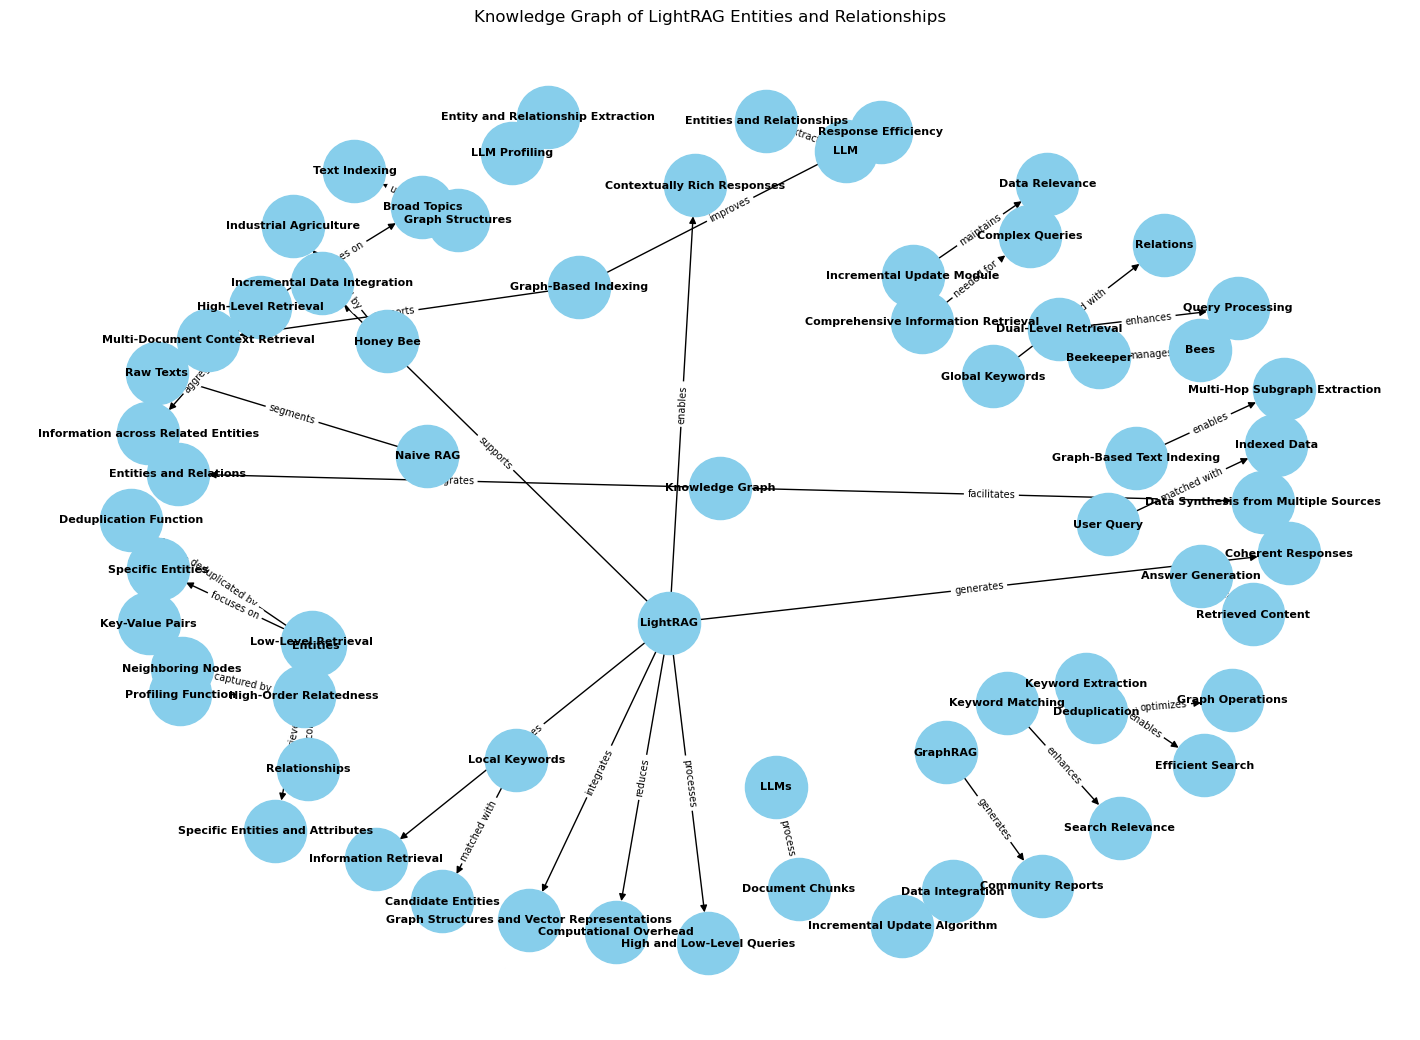

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

# Defining the triplets provided as (source, relationship, target)
triplets = [
    ("Beekeeper", "manages", "Bees"),
    ("Honey Bee", "impacted by", "Industrial Agriculture"),
    ("Graph Structures", "used in", "Text Indexing"),
    ("LightRAG", "enhances", "Information Retrieval"),
    ("LLMs", "process", "Document Chunks"),
    ("Entities", "connected to", "Relationships"),
    ("Knowledge Graph", "integrates", "Entities and Relations"),
    ("Incremental Update Algorithm", "supports", "Data Integration"),
    ("Dual-Level Retrieval", "enhances", "Query Processing"),
    ("LightRAG", "integrates", "Graph Structures and Vector Representations"),
    ("Low-Level Retrieval", "focuses on", "Specific Entities"),
    ("High-Level Retrieval", "focuses on", "Broad Topics"),
    ("LightRAG", "enables", "Contextually Rich Responses"),
    ("Graph-Based Text Indexing", "enables", "Multi-Hop Subgraph Extraction"),
    ("LLM", "extracts", "Entities and Relationships"),
    ("Profiling Function", "generates", "Key-Value Pairs"),
    ("Deduplication", "optimizes", "Graph Operations"),
    ("LightRAG", "supports", "Incremental Data Integration"),
    ("LLM Profiling", "enhances", "Entity and Relationship Extraction"),
    ("Naive RAG", "segments", "Raw Texts"),
    ("GraphRAG", "generates", "Community Reports"),
    ("User Query", "matched with", "Indexed Data"),
    ("LightRAG", "processes", "High and Low-Level Queries"),
    ("Comprehensive Information Retrieval", "needed for", "Complex Queries"),
    ("Graph-Based Indexing", "supports", "Multi-Document Context Retrieval"),
    ("Knowledge Graph", "facilitates", "Data Synthesis from Multiple Sources"),
    ("Retrieved Content", "utilized in", "Answer Generation"),
    ("Low-Level Retrieval", "retrieves", "Specific Entities and Attributes"),
    ("High-Level Retrieval", "aggregates", "Information across Related Entities"),
    ("Keyword Extraction", "enables", "Efficient Search"),
    ("Local Keywords", "matched with", "Candidate Entities"),
    ("Global Keywords", "matched with", "Relations"),
    ("Keyword Matching", "enhances", "Search Relevance"),
    ("LightRAG", "generates", "Coherent Responses"),
    ("Graph-Based Indexing", "improves", "Response Efficiency"),
    ("LightRAG", "reduces", "Computational Overhead"),
    ("Incremental Update Module", "maintains", "Data Relevance"),
    ("Entities", "deduplicated by", "Deduplication Function"),
    ("High-Order Relatedness", "captured by", "Neighboring Nodes")
]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph from triplets
for source, relationship, target in triplets:
    G.add_node(source)
    G.add_node(target)
    G.add_edge(source, target, label=relationship)

# Plotting the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.3, seed=42)  # layout for a better spread of nodes
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=8, font_weight="bold", arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)
plt.title("Knowledge Graph of LightRAG Entities and Relationships")
plt.show()

In [29]:
#!pip install orkg

from orkg import ORKG

# Initialize ORKG client
client = ORKG(host="https://www.orkg.org/orkg")

# List of triplets
triplets = [
    ("Beekeeper", "manages", "Bees"),
    ("Honey Bee", "impacted by", "Industrial Agriculture"),
    ("Graph Structures", "used in", "Text Indexing"),
    ("LightRAG", "enhances", "Information Retrieval"),
    ("LLMs", "process", "Document Chunks"),
    ("Entities", "connected to", "Relationships"),
    ("Knowledge Graph", "integrates", "Entities and Relations"),
    ("Incremental Update Algorithm", "supports", "Data Integration"),
    ("Dual-Level Retrieval", "enhances", "Query Processing"),
    ("LightRAG", "integrates", "Graph Structures and Vector Representations"),
    ("Low-Level Retrieval", "focuses on", "Specific Entities"),
    ("High-Level Retrieval", "focuses on", "Broad Topics"),
    ("LightRAG", "enables", "Contextually Rich Responses"),
    ("Graph-Based Text Indexing", "enables", "Multi-Hop Subgraph Extraction"),
    ("LLM", "extracts", "Entities and Relationships"),
    ("Profiling Function", "generates", "Key-Value Pairs"),
    ("Deduplication", "optimizes", "Graph Operations"),
    ("LightRAG", "supports", "Incremental Data Integration"),
    ("LLM Profiling", "enhances", "Entity and Relationship Extraction"),
    ("Naive RAG", "segments", "Raw Texts"),
    ("GraphRAG", "generates", "Community Reports"),
    ("User Query", "matched with", "Indexed Data"),
    ("LightRAG", "processes", "High and Low-Level Queries"),
    ("Comprehensive Information Retrieval", "needed for", "Complex Queries"),
    ("Graph-Based Indexing", "supports", "Multi-Document Context Retrieval"),
    ("Knowledge Graph", "facilitates", "Data Synthesis from Multiple Sources"),
    ("Retrieved Content", "utilized in", "Answer Generation"),
    ("Low-Level Retrieval", "retrieves", "Specific Entities and Attributes"),
    ("High-Level Retrieval", "aggregates", "Information across Related Entities"),
    ("Keyword Extraction", "enables", "Efficient Search"),
    ("Local Keywords", "matched with", "Candidate Entities"),
    ("Global Keywords", "matched with", "Relations"),
    ("Keyword Matching", "enhances", "Search Relevance"),
    ("LightRAG", "generates", "Coherent Responses"),
    ("Graph-Based Indexing", "improves", "Response Efficiency"),
    ("LightRAG", "reduces", "Computational Overhead"),
    ("Incremental Update Module", "maintains", "Data Relevance"),
    ("Entities", "deduplicated by", "Deduplication Function"),
    ("High-Order Relatedness", "captured by", "Neighboring Nodes"),
    ("LightRAG", "leverages", "LLM Capabilities"),
    ("Graph-Based Subgraphs", "utilized in", "Complex Retrieval Tasks"),
    ("Contextual Information", "enhances", "User Queries"),
    ("Graph Structures", "facilitate", "Entity Connectivity"),
    ("Answer Generation", "supported by", "Multi-Hop Retrieval"),
    ("Local Relationships", "identified by", "Entity Matching"),
    ("Global Knowledge", "consolidated through", "Graph Indexing"),
    ("LLMs", "enhanced by", "LightRAG Processing"),
    ("Indexed Data", "supports", "Fast Query Matching"),
    ("Community Reports", "enhanced with", "GraphRAG Techniques"),
    ("Entity Relationships", "mapped by", "Knowledge Graphs"),
    ("User Queries", "processed with", "Incremental Retrieval Techniques")
]

# Create the graph in ORKG
for subject, predicate, obj in triplets:
    # Add or retrieve resources for subject and object
    subject_resource = client.resources.add(label=subject)
    object_resource = client.resources.add(label=obj)
    
    # Add or retrieve the predicate
    predicate_resource = client.predicates.add(label=predicate)
    
    # Add the statement (triplet)
    client.statements.add(
        subject_id=subject_resource["id"],
        predicate_id=predicate_resource["id"],
        object_id=object_resource["id"]
    )

print("Knowledge graph successfully created in ORKG!")


AuthenticationRequiredError: You must first pass your ORKG credentials to perform this action!

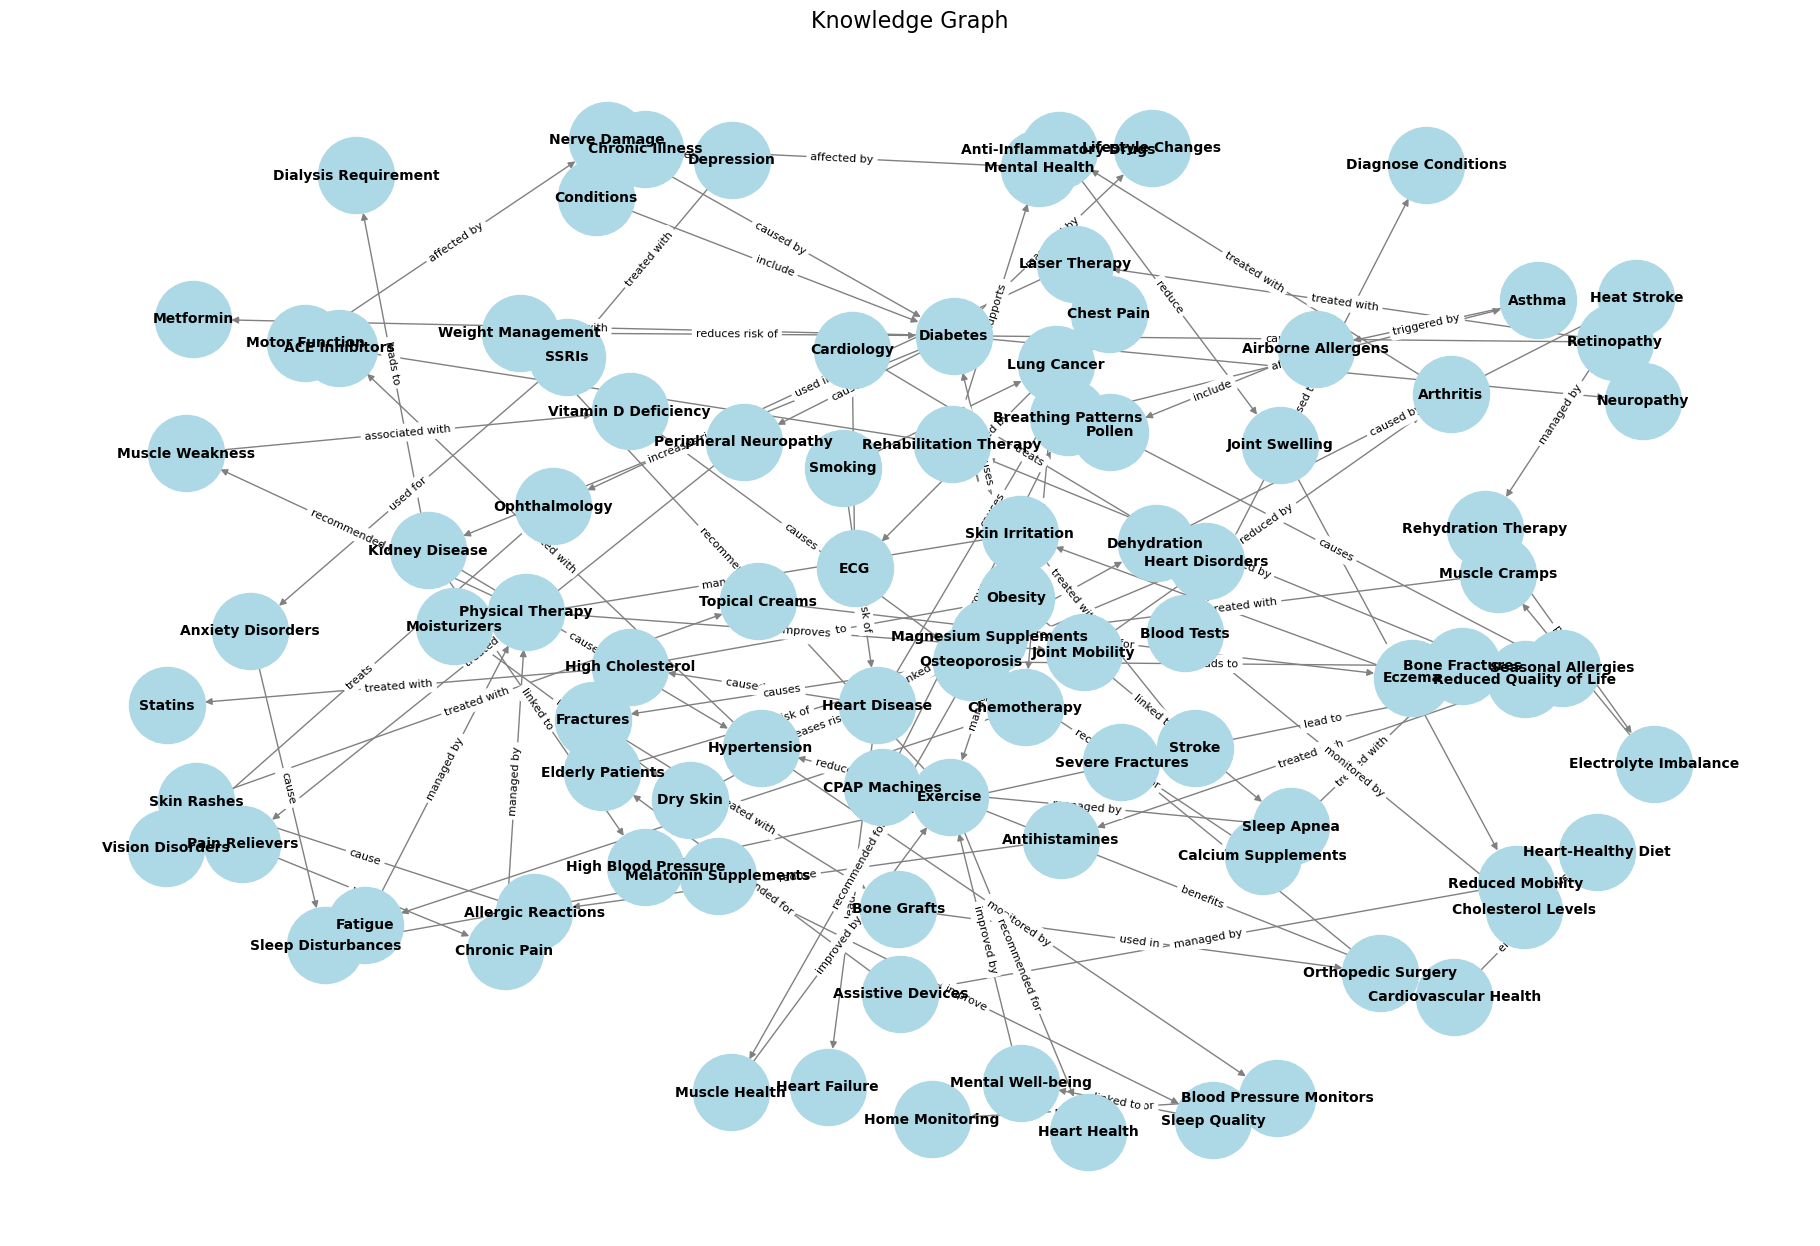

RELdir: {('Diabetes', 'Neuropathy'): 'causes', ('Diabetes', 'Kidney Disease'): 'increases risk of', ('Diabetes', 'Metformin'): 'treated with', ('Diabetes', 'Lifestyle Changes'): 'managed by', ('Kidney Disease', 'Dialysis Requirement'): 'leads to', ('Kidney Disease', 'Hypertension'): 'caused by', ('Hypertension', 'Heart Disease'): 'increases risk of', ('Hypertension', 'ACE Inhibitors'): 'treated with', ('Heart Disease', 'Heart Failure'): 'leads to', ('Heart Disease', 'High Cholesterol'): 'caused by', ('High Cholesterol', 'Statins'): 'treated with', ('High Cholesterol', 'Obesity'): 'linked to', ('Obesity', 'Diabetes'): 'causes', ('Obesity', 'Exercise'): 'managed by', ('Exercise', 'Hypertension'): 'reduces risk of', ('Exercise', 'Heart Health'): 'recommended for', ('Smoking', 'Lung Cancer'): 'causes', ('Smoking', 'Heart Disease'): 'increases risk of', ('Lung Cancer', 'Chemotherapy'): 'treated with', ('Chemotherapy', 'Fatigue'): 'causes', ('Fatigue', 'Physical Therapy'): 'managed by', ('Ph

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Input triplets
triplets = triplets = [
    ("Diabetes", "causes", "Neuropathy"),
    ("Diabetes", "increases risk of", "Kidney Disease"),
    ("Diabetes", "treated with", "Metformin"),
    ("Diabetes", "managed by", "Lifestyle Changes"),
    ("Kidney Disease", "leads to", "Dialysis Requirement"),
    ("Kidney Disease", "caused by", "Hypertension"),
    ("Hypertension", "increases risk of", "Heart Disease"),
    ("Hypertension", "treated with", "ACE Inhibitors"),
    ("Heart Disease", "leads to", "Heart Failure"),
    ("Heart Disease", "caused by", "High Cholesterol"),
    ("High Cholesterol", "treated with", "Statins"),
    ("High Cholesterol", "linked to", "Obesity"),
    ("Obesity", "causes", "Diabetes"),
    ("Obesity", "managed by", "Exercise"),
    ("Exercise", "reduces risk of", "Hypertension"),
    ("Exercise", "recommended for", "Heart Health"),
    ("Smoking", "causes", "Lung Cancer"),
    ("Smoking", "increases risk of", "Heart Disease"),
    ("Lung Cancer", "treated with", "Chemotherapy"),
    ("Chemotherapy", "causes", "Fatigue"),
    ("Fatigue", "managed by", "Physical Therapy"),
    ("Physical Therapy", "recommended for", "Muscle Weakness"),
    ("Muscle Weakness", "associated with", "Vitamin D Deficiency"),
    ("Vitamin D Deficiency", "causes", "Osteoporosis"),
    ("Osteoporosis", "leads to", "Bone Fractures"),
    ("Bone Fractures", "treated with", "Calcium Supplements"),
    ("Calcium Supplements", "recommended for", "Osteoporosis"),
    ("Diabetes", "causes", "Retinopathy"),
    ("Retinopathy", "treated with", "Laser Therapy"),
    ("Laser Therapy", "used in", "Ophthalmology"),
    ("Ophthalmology", "treats", "Vision Disorders"),
    ("Kidney Disease", "linked to", "High Blood Pressure"),
    ("High Blood Pressure", "causes", "Stroke"),
    ("Stroke", "treated with", "Rehabilitation Therapy"),
    ("Rehabilitation Therapy", "improves", "Motor Function"),
    ("Motor Function", "affected by", "Nerve Damage"),
    ("Nerve Damage", "caused by", "Diabetes"),
    ("Heart Disease", "causes", "Chest Pain"),
    ("Chest Pain", "diagnosed by", "ECG"),
    ("ECG", "used in", "Cardiology"),
    ("Cardiology", "treats", "Heart Disorders"),
    ("Heart Disorders", "linked to", "Hypertension"),
    ("Hypertension", "monitored by", "Blood Pressure Monitors"),
    ("Blood Pressure Monitors", "recommended for", "Home Monitoring"),
    ("Obesity", "linked to", "Sleep Apnea"),
    ("Sleep Apnea", "managed by", "CPAP Machines"),
    ("CPAP Machines", "improve", "Breathing Patterns"),
    ("Breathing Patterns", "affected by", "Asthma"),
    ("Asthma", "triggered by", "Airborne Allergens"),
    ("Airborne Allergens", "include", "Pollen"),
    ("Pollen", "causes", "Seasonal Allergies"),
    ("Seasonal Allergies", "treated with", "Antihistamines"),
    ("Antihistamines", "reduce", "Allergic Reactions"),
    ("Allergic Reactions", "cause", "Skin Rashes"),
    ("Skin Rashes", "treated with", "Topical Creams"),
    ("Topical Creams", "recommended for", "Eczema"),
    ("Eczema", "causes", "Skin Irritation"),
    ("Skin Irritation", "managed by", "Moisturizers"),
    ("Moisturizers", "reduce", "Dry Skin"),
    ("Dry Skin", "linked to", "Dehydration"),
    ("Dehydration", "caused by", "Heat Stroke"),
    ("Heat Stroke", "managed by", "Rehydration Therapy"),
    ("Rehydration Therapy", "prevents", "Electrolyte Imbalance"),
    ("Electrolyte Imbalance", "causes", "Muscle Cramps"),
    ("Muscle Cramps", "treated with", "Magnesium Supplements"),
    ("Magnesium Supplements", "recommended for", "Muscle Health"),
    ("Muscle Health", "improved by", "Exercise"),
    ("Exercise", "recommended for", "Weight Management"),
    ("Weight Management", "reduces risk of", "Diabetes"),
    ("Diabetes", "causes", "Peripheral Neuropathy"),
    ("Peripheral Neuropathy", "treated with", "Pain Relievers"),
    ("Pain Relievers", "used for", "Chronic Pain"),
    ("Chronic Pain", "managed by", "Physical Therapy"),
    ("Physical Therapy", "improves", "Joint Mobility"),
    ("Joint Mobility", "reduced by", "Arthritis"),
    ("Arthritis", "treated with", "Anti-Inflammatory Drugs"),
    ("Anti-Inflammatory Drugs", "reduce", "Joint Swelling"),
    ("Joint Swelling", "causes", "Reduced Mobility"),
    ("Reduced Mobility", "managed by", "Assistive Devices"),
    ("Assistive Devices", "recommended for", "Elderly Patients"),
    ("Elderly Patients", "at risk of", "Osteoporosis"),
    ("Osteoporosis", "causes", "Fractures"),
    ("Fractures", "treated with", "Bone Grafts"),
    ("Bone Grafts", "used in", "Orthopedic Surgery"),
    ("Orthopedic Surgery", "required for", "Severe Fractures"),
    ("Severe Fractures", "lead to", "Reduced Quality of Life"),
    ("Reduced Quality of Life", "improved by", "Rehabilitation Therapy"),
    ("Rehabilitation Therapy", "supports", "Mental Health"),
    ("Mental Health", "affected by", "Chronic Illness"),
    ("Chronic Illness", "linked to", "Depression"),
    ("Depression", "treated with", "SSRIs"),
    ("SSRIs", "used for", "Anxiety Disorders"),
    ("Anxiety Disorders", "cause", "Sleep Disturbances"),
    ("Sleep Disturbances", "managed by", "Melatonin Supplements"),
    ("Melatonin Supplements", "improve", "Sleep Quality"),
    ("Sleep Quality", "linked to", "Mental Well-being"),
    ("Mental Well-being", "improved by", "Exercise"),
    ("Exercise", "benefits", "Cardiovascular Health"),
    ("Cardiovascular Health", "enhanced by", "Heart-Healthy Diet"),
    ("Heart-Healthy Diet", "reduces", "Cholesterol Levels"),
    ("Cholesterol Levels", "monitored by", "Blood Tests"),
    ("Blood Tests", "used to", "Diagnose Conditions"),
    ("Conditions", "include", "Diabetes"),
]

# Define functions for building the knowledge graph
def BuildKG(triplets):
    # Initialize a directed graph
    G = nx.DiGraph()

    # Dictionary for nodes and their attributes
    NERdir = {}
    RELdir = {}

    # Add nodes and edges from triplets
    for head, relation, tail in triplets:
        G.add_edge(head, tail, label=relation)

        # Map nodes to attributes
        if head not in NERdir:
            NERdir[head] = head
        if tail not in NERdir:
            NERdir[tail] = tail
        RELdir[(head, tail)] = relation

    return G, NERdir, RELdir

# Build the graph
G, NERdir, RELdir = BuildKG(triplets)

# Visualize the graph
plt.figure(figsize=(18, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw(
    G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray"
)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Knowledge Graph", fontsize=16)
plt.show()


print("RELdir:", RELdir)


In [36]:
!pip install pyvis
from pyvis.network import Network

# Create a Pyvis network
net = Network(height="750px", width="100%", notebook=True, directed=True)

# Add nodes and edges
for subj, pred, obj in triplets:
    net.add_node(subj, label=subj, color="lightblue")
    net.add_node(obj, label=obj, color="lightgreen")
    net.add_edge(subj, obj, title=pred)

# Customize layout
net.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 15
    }
  },
  "edges": {
    "arrows": {
      "to": {
        "enabled": true
      }
    },
    "font": {
      "align": "middle"
    },
    "smooth": true
  },
  "physics": {
    "enabled": true,
    "barnesHut": {
      "gravitationalConstant": -8000,
      "centralGravity": 0.3,
      "springLength": 95,
      "springConstant": 0.04
    }
  }
}
""")

# Show the graph
net.show("knowledge_graph.html")


knowledge_graph.html


In [38]:
from orkg import ORKG
import networkx as nx
import matplotlib.pyplot as plt

# Replace 'your_email' and 'your_password' with your ORKG account credentials
client = ORKG(email='yashna401@gmail.com', password='Aashi$20021999')

# List of triplets
triplets = [
    ("Beekeeper", "manages", "Bees"),
    ("Honey Bee", "impacted by", "Industrial Agriculture"),
    ("Graph Structures", "used in", "Text Indexing"),
    ("LightRAG", "enhances", "Information Retrieval"),
    ("LLMs", "process", "Document Chunks"),
   
]

# Create the graph in ORKG
for subject, predicate, obj in triplets:
    # Add or retrieve resources for subject and object
    subject_resource = client.resources.add(label=subject)
    object_resource = client.resources.add(label=obj)
    
    # Add or retrieve the predicate
    predicate_resource = client.predicates.add(label=predicate)
    
    # Add the statement (triplet)
    client.statements.add(
        subject_id=subject_resource["id"],
        predicate_id=predicate_resource["id"],
        object_id=object_resource["id"]
    )

print("Knowledge graph successfully created in ORKG!")

# Visualization using NetworkX
G = nx.DiGraph()

# Add nodes and edges from triplets
for subject, predicate, obj in triplets:
    G.add_edge(subject, obj, label=predicate)

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization
plt.figure(figsize=(15, 10))
nx.draw(
    G, pos, with_labels=True, node_size=3000, node_color="lightblue",
    font_size=10, font_weight="bold", arrowsize=15
)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color="red")
plt.title("Knowledge Graph Visualization", fontsize=16)
plt.show()


AuthenticationRequiredError: You must first pass your ORKG credentials to perform this action!

In [8]:
from pyvis.network import Network

class InterdependentKnowledgeGraph:
    def __init__(self):
        # Dictionary to store the graph: {node: [(relation, connected_node), ...]}
        self.graph = {}

    def add_triplet(self, subject, relation, obj):
        """
        Add a triplet to the graph ensuring no duplicate nodes or relations.
        """
        # Initialize the nodes in the graph if not already present
        if subject not in self.graph:
            self.graph[subject] = set()  # Use a set to avoid duplicate relations
        if obj not in self.graph:
            self.graph[obj] = set()
        # Add the relationship
        self.graph[subject].add((relation, obj))

    def display_graph(self):
        """
        Print the graph structure in a human-readable format.
        """
        print("\nKnowledge Graph Structure:")
        for node, edges in self.graph.items():
            for relation, connected_node in edges:
                print(f"{node} --[{relation}]--> {connected_node}")

    def visualize_interactive(self, output_file="knowledge_graph.html"):
        """
        Create an interactive visualization of the graph using pyvis.
        """
        net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="black")

        # Add nodes and edges
        for subject, edges in self.graph.items():
            net.add_node(subject, label=subject, title=subject)
            for relation, obj in edges:
                net.add_node(obj, label=obj, title=obj)
                net.add_edge(subject, obj, title=relation, label=relation)

        # Generate and save the visualization
        net.show(output_file)
        print(f"Graph saved as {output_file}")


# Example Usage
if __name__ == "__main__":
    # Define the triplets
    triplets = [
    ("Diabetes", "causes", "Neuropathy"),
    ("Diabetes", "increases risk of", "Kidney Disease"),
    ("Diabetes", "treated with", "Metformin"),
    ("Diabetes", "managed by", "Lifestyle Changes"),
    ("Kidney Disease", "leads to", "Dialysis Requirement"),
    ("Kidney Disease", "caused by", "Hypertension"),
    ("Hypertension", "increases risk of", "Heart Disease"),
    ("Hypertension", "treated with", "ACE Inhibitors"),
    ("Heart Disease", "leads to", "Heart Failure"),
    ("Heart Disease", "caused by", "High Cholesterol"),
    ("High Cholesterol", "treated with", "Statins"),
    ("High Cholesterol", "linked to", "Obesity"),
    ("Obesity", "causes", "Diabetes"),
    ("Obesity", "managed by", "Exercise"),
    ("Exercise", "reduces risk of", "Hypertension"),
    ("Exercise", "recommended for", "Heart Health"),
    ("Smoking", "causes", "Lung Cancer"),
    ("Smoking", "increases risk of", "Heart Disease"),
    ("Lung Cancer", "treated with", "Chemotherapy"),
    ("Chemotherapy", "causes", "Fatigue"),
    ("Fatigue", "managed by", "Physical Therapy"),
    ("Physical Therapy", "recommended for", "Muscle Weakness"),
    ("Muscle Weakness", "associated with", "Vitamin D Deficiency"),
    ("Vitamin D Deficiency", "causes", "Osteoporosis"),
    ("Osteoporosis", "leads to", "Bone Fractures"),
    ("Bone Fractures", "treated with", "Calcium Supplements"),
    ("Calcium Supplements", "recommended for", "Osteoporosis"),
    ("Diabetes", "causes", "Retinopathy"),
    ("Retinopathy", "treated with", "Laser Therapy"),
    ("Laser Therapy", "used in", "Ophthalmology"),
    ("Ophthalmology", "treats", "Vision Disorders"),
    ("Kidney Disease", "linked to", "High Blood Pressure"),
    ("High Blood Pressure", "causes", "Stroke"),
    ("Stroke", "treated with", "Rehabilitation Therapy"),
    ("Rehabilitation Therapy", "improves", "Motor Function"),
    ("Motor Function", "affected by", "Nerve Damage"),
    ("Nerve Damage", "caused by", "Diabetes"),
    ("Heart Disease", "causes", "Chest Pain"),
    ("Chest Pain", "diagnosed by", "ECG"),
    ("ECG", "used in", "Cardiology"),
    ("Cardiology", "treats", "Heart Disorders"),
    ("Heart Disorders", "linked to", "Hypertension"),
    ("Hypertension", "monitored by", "Blood Pressure Monitors"),
    ("Blood Pressure Monitors", "recommended for", "Home Monitoring"),
    ("Obesity", "linked to", "Sleep Apnea"),
    ("Sleep Apnea", "managed by", "CPAP Machines"),
    ("CPAP Machines", "improve", "Breathing Patterns"),
    ("Breathing Patterns", "affected by", "Asthma"),
    ("Asthma", "triggered by", "Airborne Allergens"),
    ("Airborne Allergens", "include", "Pollen"),
    ("Pollen", "causes", "Seasonal Allergies"),
    ("Seasonal Allergies", "treated with", "Antihistamines"),
    ("Antihistamines", "reduce", "Allergic Reactions"),
    ("Allergic Reactions", "cause", "Skin Rashes"),
    ("Skin Rashes", "treated with", "Topical Creams"),
    ("Topical Creams", "recommended for", "Eczema"),
    ("Eczema", "causes", "Skin Irritation"),
    ("Skin Irritation", "managed by", "Moisturizers"),
    ("Moisturizers", "reduce", "Dry Skin"),
    ("Dry Skin", "linked to", "Dehydration"),
    ("Dehydration", "caused by", "Heat Stroke"),
    ("Heat Stroke", "managed by", "Rehydration Therapy"),
    ("Rehydration Therapy", "prevents", "Electrolyte Imbalance"),
    ("Electrolyte Imbalance", "causes", "Muscle Cramps"),
    ("Muscle Cramps", "treated with", "Magnesium Supplements"),
    ("Magnesium Supplements", "recommended for", "Muscle Health"),
    ("Muscle Health", "improved by", "Exercise"),
    ("Exercise", "recommended for", "Weight Management"),
    ("Weight Management", "reduces risk of", "Diabetes"),
    ("Diabetes", "causes", "Peripheral Neuropathy"),
    ("Peripheral Neuropathy", "treated with", "Pain Relievers"),
    ("Pain Relievers", "used for", "Chronic Pain"),
    ("Chronic Pain", "managed by", "Physical Therapy"),
    ("Physical Therapy", "improves", "Joint Mobility"),
    ("Joint Mobility", "reduced by", "Arthritis"),
    ("Arthritis", "treated with", "Anti-Inflammatory Drugs"),
    ("Anti-Inflammatory Drugs", "reduce", "Joint Swelling"),
    ("Joint Swelling", "causes", "Reduced Mobility"),
    ("Reduced Mobility", "managed by", "Assistive Devices"),
    ("Assistive Devices", "recommended for", "Elderly Patients"),
    ("Elderly Patients", "at risk of", "Osteoporosis"),
    ("Osteoporosis", "causes", "Fractures"),
    ("Fractures", "treated with", "Bone Grafts"),
    ("Bone Grafts", "used in", "Orthopedic Surgery"),
    ("Orthopedic Surgery", "required for", "Severe Fractures"),
    ("Severe Fractures", "lead to", "Reduced Quality of Life"),
    ("Reduced Quality of Life", "improved by", "Rehabilitation Therapy"),
    ("Rehabilitation Therapy", "supports", "Mental Health"),
    ("Mental Health", "affected by", "Chronic Illness"),
    ("Chronic Illness", "linked to", "Depression"),
    ("Depression", "treated with", "SSRIs"),
    ("SSRIs", "used for", "Anxiety Disorders"),
    ("Anxiety Disorders", "cause", "Sleep Disturbances"),
    ("Sleep Disturbances", "managed by", "Melatonin Supplements"),
    ("Melatonin Supplements", "improve", "Sleep Quality"),
    ("Sleep Quality", "linked to", "Mental Well-being"),
    ("Mental Well-being", "improved by", "Exercise"),
    ("Exercise", "benefits", "Cardiovascular Health"),
    ("Cardiovascular Health", "enhanced by", "Heart-Healthy Diet"),
    ("Heart-Healthy Diet", "reduces", "Cholesterol Levels"),
    ("Cholesterol Levels", "monitored by", "Blood Tests"),
    ("Blood Tests", "used to", "Diagnose Conditions"),
    ("Conditions", "include", "Diabetes"),
]


    # Create an instance of the graph
    knowledge_graph = InterdependentKnowledgeGraph()

    # Add triplets to the graph
    for subject, relation, obj in triplets:
        knowledge_graph.add_triplet(subject, relation, obj)

    # Display and visualize the graph
    knowledge_graph.display_graph()
    knowledge_graph.visualize_interactive()



Knowledge Graph Structure:
Diabetes --[increases risk of]--> Kidney Disease
Diabetes --[causes]--> Neuropathy
Diabetes --[causes]--> Peripheral Neuropathy
Diabetes --[causes]--> Retinopathy
Diabetes --[treated with]--> Metformin
Diabetes --[managed by]--> Lifestyle Changes
Kidney Disease --[caused by]--> Hypertension
Kidney Disease --[leads to]--> Dialysis Requirement
Kidney Disease --[linked to]--> High Blood Pressure
Hypertension --[increases risk of]--> Heart Disease
Hypertension --[treated with]--> ACE Inhibitors
Hypertension --[monitored by]--> Blood Pressure Monitors
Heart Disease --[leads to]--> Heart Failure
Heart Disease --[caused by]--> High Cholesterol
Heart Disease --[causes]--> Chest Pain
High Cholesterol --[linked to]--> Obesity
High Cholesterol --[treated with]--> Statins
Obesity --[causes]--> Diabetes
Obesity --[managed by]--> Exercise
Obesity --[linked to]--> Sleep Apnea
Exercise --[recommended for]--> Heart Health
Exercise --[benefits]--> Cardiovascular Health
Exerci